In [1]:
import pickle
import joblib
import ast, os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from v1dd_public import ARTIFACT_DIR
from allen_v1dd.client import OPhysClient
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import LinearSegmentedColormap

In [2]:
## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

fontsize=13
figure_path = Path('/home/naomi/Desktop/figures/v1dd_plots')

In [3]:
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
H5_DIR = os.path.join(ARTIFACT_DIR, 'stimulus_analyses_v2.h5')
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
client =  OPhysClient(DATA_DIR)

In [4]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

In [5]:
res = ['mouse_id',
        'frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118', # please note the other fraction frac_resp_ns118 is from Chase h5 which is incorrect
        'frac_res_to_ns12', # please note the other fraction frac_resp_ns12 is from Chase h5 which is incorrect
        'frac_resp_nm',
        'z'
       ]
features = cell_info[res]  # features is a dataframe with the 7 response reliability fractions (columns) for every cell (rows) across all mice

features = features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM',
       'z': 'depth'},)

0.25
0.2857142857142857
0.375
0.125
0.4333333333333333


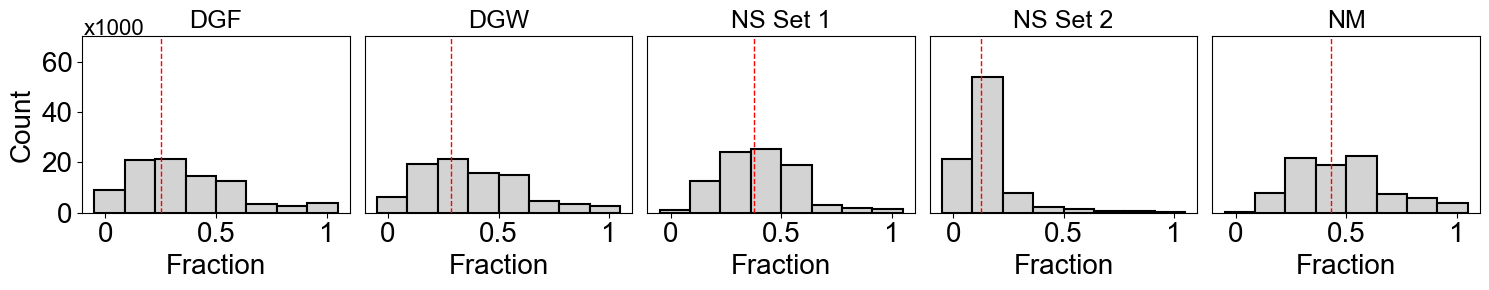

In [6]:
feature_labels = ['DGF', 'DGW', 'NI118', 'NI12', 'NM']
feature_titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2', 'NM']

plt.figure(figsize=(15,3))
fontsize = 20
for n in range(len(feature_labels)):
    plt.subplot(1, len(feature_labels), n+1)
    bins = np.linspace(-0.05, 1.05, 9).tolist()
    plt.hist(features[feature_labels[n]], bins=bins, edgecolor='black', linewidth=1.5, color='lightgray')
    
    median_value = np.median(features[feature_labels[n]])
    print(median_value)
    plt.axvline(median_value, color='r', linestyle='dashed', linewidth=1)  
    plt.title(feature_titles[n], fontsize=fontsize-2)
    plt.xlabel("Fraction", fontsize=fontsize)
    plt.ylim([0, 70000])
    plt.yticks([0, 20000, 40000, 60000], ['0', '20', '40', '60'], fontsize=fontsize)
    plt.xticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=fontsize)    
    if n == 0:
        plt.ylabel("Count", fontsize=fontsize)
        plt.text(-0.1, 73000, 'x1000', verticalalignment='center', fontsize=fontsize-4)
    else:
        plt.yticks([])

    plt.tight_layout()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG4A_fraction_histograms.svg'), dpi=300)

In [7]:
res2 = ['mouse_id',
        'frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118', # please note the other fraction frac_resp_ns118 is from Chase h5 which is incorrect
        'frac_res_to_ns12', # please note the other fraction frac_resp_ns12 is from Chase h5 which is incorrect
        'frac_resp_nm',
        'z'
       ]
features_resp = cell_info[cell_info['is_responsive'] == True][res2]  # features_resp is a dataframe with the 7 response reliability fractions (columns) for every cell (rows) across all mice

features_resp = features_resp.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM',
       'z': 'depth'},)

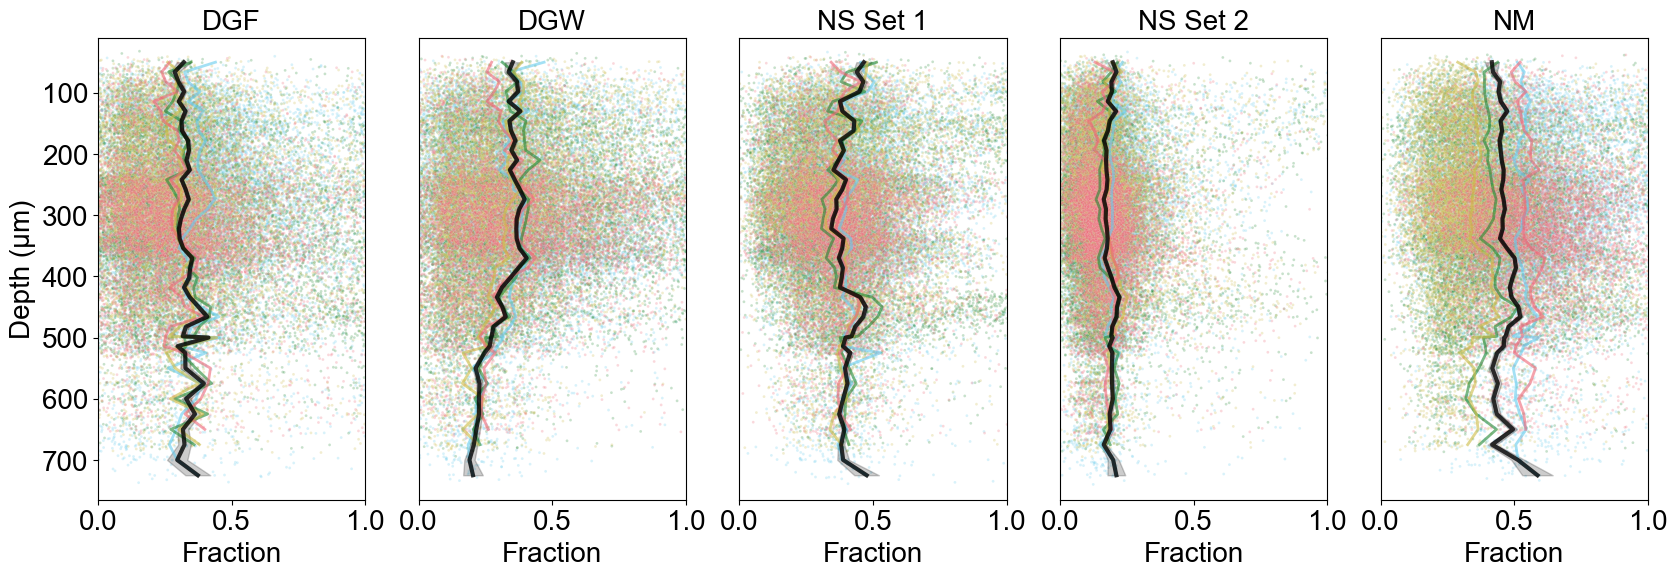

In [8]:
#### Plotting decoding accuracies for each mouse
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}

# Some parameters for the plot
z_values = features_resp['depth'].unique()
z_values = np.array(z_values)
z_values = np.sort(z_values)
stims = ['DGF', 'DGW', 'NI118', 'NI12', 'NM']
titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2', 'NM']
n_stims = len(stims)

fig, axs = plt.subplots(1, n_stims, figsize=(20, 6))
fontsize = 20

# Iterate through each stimulus type and plot the results for all the mice
for stim_idx, stim_type in enumerate(stims):
    ax = axs[stim_idx]

    sns.lineplot(
        data=features_resp,
        x=stim_type,
        y='depth',
        hue='mouse_id',
        palette=mouse_colors,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False # if stim_idx != int(n_stims-1) else True,
    )

    # ax.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4'], 
    #     loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize, title_fontsize=fontsize) if stim_idx == int(n_stims-1) else None

    sns.lineplot(data=features_resp, 
        x=stim_type, 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    # sub_df = features_resp.groupby('depth')[stim_type].mean().reset_index()
    # sub_array = sub_df[stim_type].values
    # ax.scatter(sub_array.max() + 3*sub_array.std(), sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
    #     color='black', marker='*', s=75, edgecolor='black', zorder=1)
    

    # Scatterplot of all the individual points
    temp_df = features_resp.copy()
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, 7, size=len(temp_df))
    temp_df[stim_type] = temp_df[stim_type] + np.random.normal(0, 0.05, size=len(temp_df))

    sns.scatterplot(data=temp_df,
        x=stim_type,
        y='depth',
        hue='mouse_id',
        palette=mouse_colors,
        s=4,
        alpha=0.25,
        ax=ax,
        legend=False,
        zorder=0,
    )

    ax.set_title(titles[stim_idx], fontsize=fontsize)
    ax.set_xlabel('Fraction', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else ax.set_ylabel(" ")
    ax.set_yticks([]) if stim_idx != 0 else None
    ax.set_xticks([0, 0.5, 1])
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    ax.set_xlim(0, 1)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG4B_resp_fractions_depth_trends.png'), dpi=400)

In [9]:
res3 = ['frac_resp_dgf', 'frac_resp_dgw', 'frac_res_to_ns118', 'frac_res_to_ns12', 'frac_resp_nm']
stim_names = ['Full-field Drifting Gratings', 'Windowed Drifting Gratings', 'Natural Images Set 1', 'Natural Images Set 2', 'Natural Movie']

features = cell_info[res3]
features = features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM'})

all_features = [features[f] for f in features.columns.tolist()]
features_stacked = np.vstack(all_features).T

To make TSNE plots, first get shared embedding -- takes around 25 minutes on my PC to run the cell below

In [11]:
perplexity = 50
early_exaggeration = 12.0
learning_rate = 500

tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        early_exaggeration=early_exaggeration,
        learning_rate=learning_rate,
        random_state=42
    )
    
embedding = tsne.fit_transform(features_stacked)

In [12]:
colors = []
colors.extend([(i/255, i/255, i/255) for i in np.linspace(80, 200, 128)])
colors.extend([(1, i/255, i/255) for i in np.linspace(200, 30, 128)])
custom_gray_cmap = LinearSegmentedColormap.from_list("custom_gray_to_red", colors, N=256)

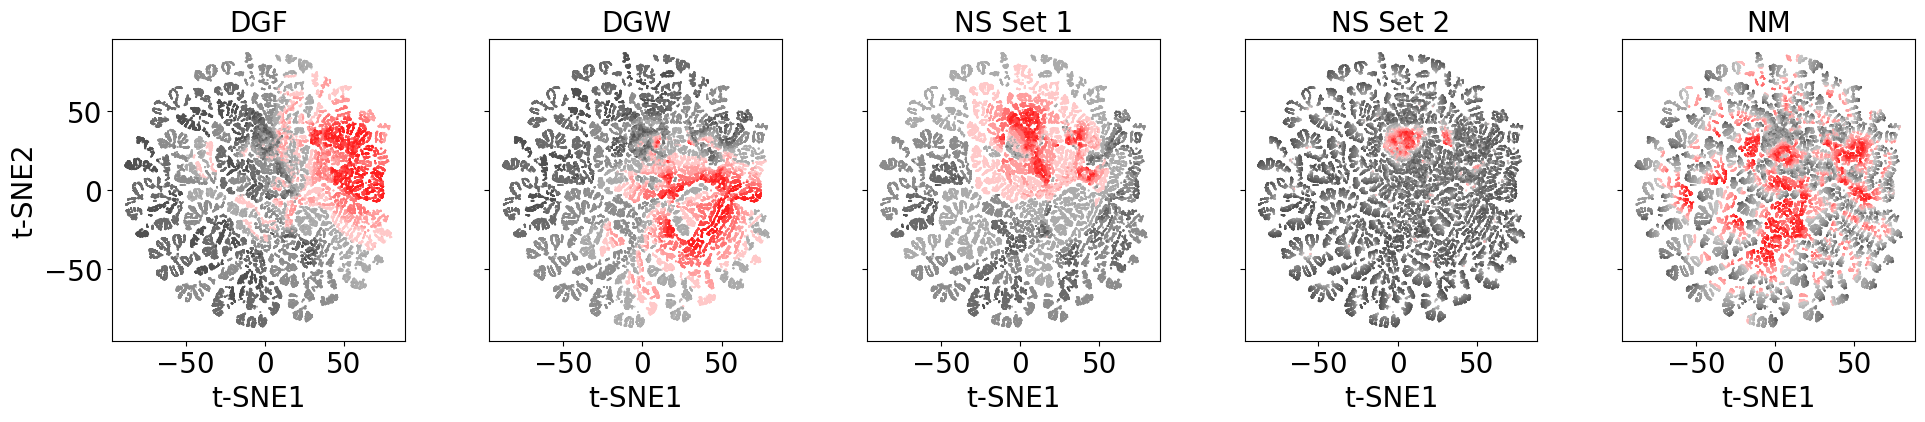

In [29]:
fig, axs = plt.subplots(1, len(stim_names), figsize=(20, 4), sharex=True, sharey=True)
fontsize = 20

stim_names = ['Full-field Drifting Gratings', 'Windowed Drifting Gratings', 'Natural Images Set 1', 'Natural Images Set 2', 'Natural Movie']
titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2', 'NM']
unique_labels = np.unique(features_stacked)
label_to_color = {label: idx for idx, label in enumerate(unique_labels)}

for idx, stim_title in enumerate(titles):
    ax = axs[idx]
    X_subset_labels = features_stacked[:, idx]
    color_labels = np.array([label_to_color[label] for label in X_subset_labels])
    sc = ax.scatter(
            x=embedding[:, 0],
            y=embedding[:, 1],
            c=color_labels,
            cmap=custom_gray_cmap,
            alpha=1,
            s=0.1,

        )

    # plt.colorbar(sc, ax=ax)
    ax.set_aspect('equal')
    ax.set_title(stim_title, fontsize=fontsize)
    ax.set_xlabel('t-SNE1', fontsize=fontsize) 
    ax.set_ylabel('t-SNE2', fontsize=fontsize) if idx == 0 else None
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()
# plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG4C_tSNE_clusters_by_stimulus_responsiveness.svg'), dpi=300)
plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG4C_tSNE_clusters_by_stimulus_responsiveness.png'), dpi=300)


### make supplementary t-sne figures (color by column, mouse, depth)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


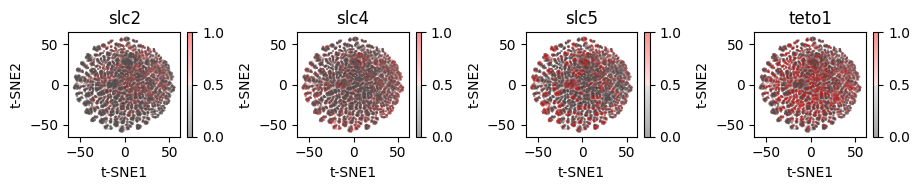

In [22]:
mouse_ids = cell_info['mouse_id'].values
mice = cell_info['mouse_id'].unique()

plt.figure(figsize=(16, 2))
for j in range(4):
    X_subset = X
    X_subset_labels = mouse_ids == mice[j]
    X_subset_labels = X_subset_labels.astype(int)
    ax = plt.subplot(1, 7, j+1)
    create_tsne_plot_2d(X_subset, X_subset_labels, stim_name=mice[j], ax=ax, perplexity=30, \
        early_exaggeration=12.0, learning_rate=200, cmap=custom_gray_cmap)

plt.savefig('/home/naomi/Desktop/figures/v1dd_plots/supp_tsne_mice.eps', format='eps', dpi=300)

### GMM Clustering

In [28]:
res2 = ['frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118',
        'frac_resp_nm'
       ]
features = cell_info[res2]

features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI',
       'frac_resp_nm':'NM'},
        inplace = True)

all_features = [features[f] for f in features.columns.tolist()]
features_stacked = np.vstack(all_features).T
X = features_stacked

/tmp/ipykernel_466537/1906151156.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns = {


In [12]:
from sklearn.model_selection import KFold
from tqdm import tqdm
from joblib import Parallel, delayed

def evaluate_iteration(i, component_range, X, kf):
    mean_bics = []

    for n_components in component_range:
        # print(f"Evaluating n_components={n_components}")
        fold_bics = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            gmm = GaussianMixture(n_components=n_components, covariance_type='full', n_init=2, random_state=i)
            gmm.fit(X_train)
            bic = gmm.bic(X_test)
            fold_bics.append(bic)
        
        mean_bics.append(np.mean(fold_bics))
    optimal_k = component_range[np.argmin(mean_bics)]

    return i, component_range, mean_bics, optimal_k

# already defined X in cell above
# X_sub = X[:10000, :]
kf = KFold(n_splits=4, shuffle=True, random_state=5)
component_range = range(1, 51)

# Run in parallel
results_list = Parallel(n_jobs=10)(
    delayed(evaluate_iteration)(
        i, component_range, X, kf
    ) for i in tqdm(range(100))
)

 10%|█         | 10/100 [00:19<00:01, 54.87it/s]

KeyboardInterrupt: 

In [ ]:
# Combine into results dictionary
results = {
    'iteration_num': [r['iteration_num'] for r in results_list],
    'n_components': [r['n_components'] for r in results_list],
    'mean_bics': [r['mean_bics'] for r in results_list],
    'optimal_k': [r['optimal_k'] for r in results_list],
}

In [ ]:
optimal_k = component_range[np.argmin(mean_bics)]
print(f"Optimal number of components: {optimal_k}")

Optimal number of components: 42


In [ ]:
final_gmm = GaussianMixture(n_components=component_range[np.argmin(mean_bics)], covariance_type='full', random_state=42)
final_gmm.fit(X)
cluster_assignments = final_gmm.predict(X)

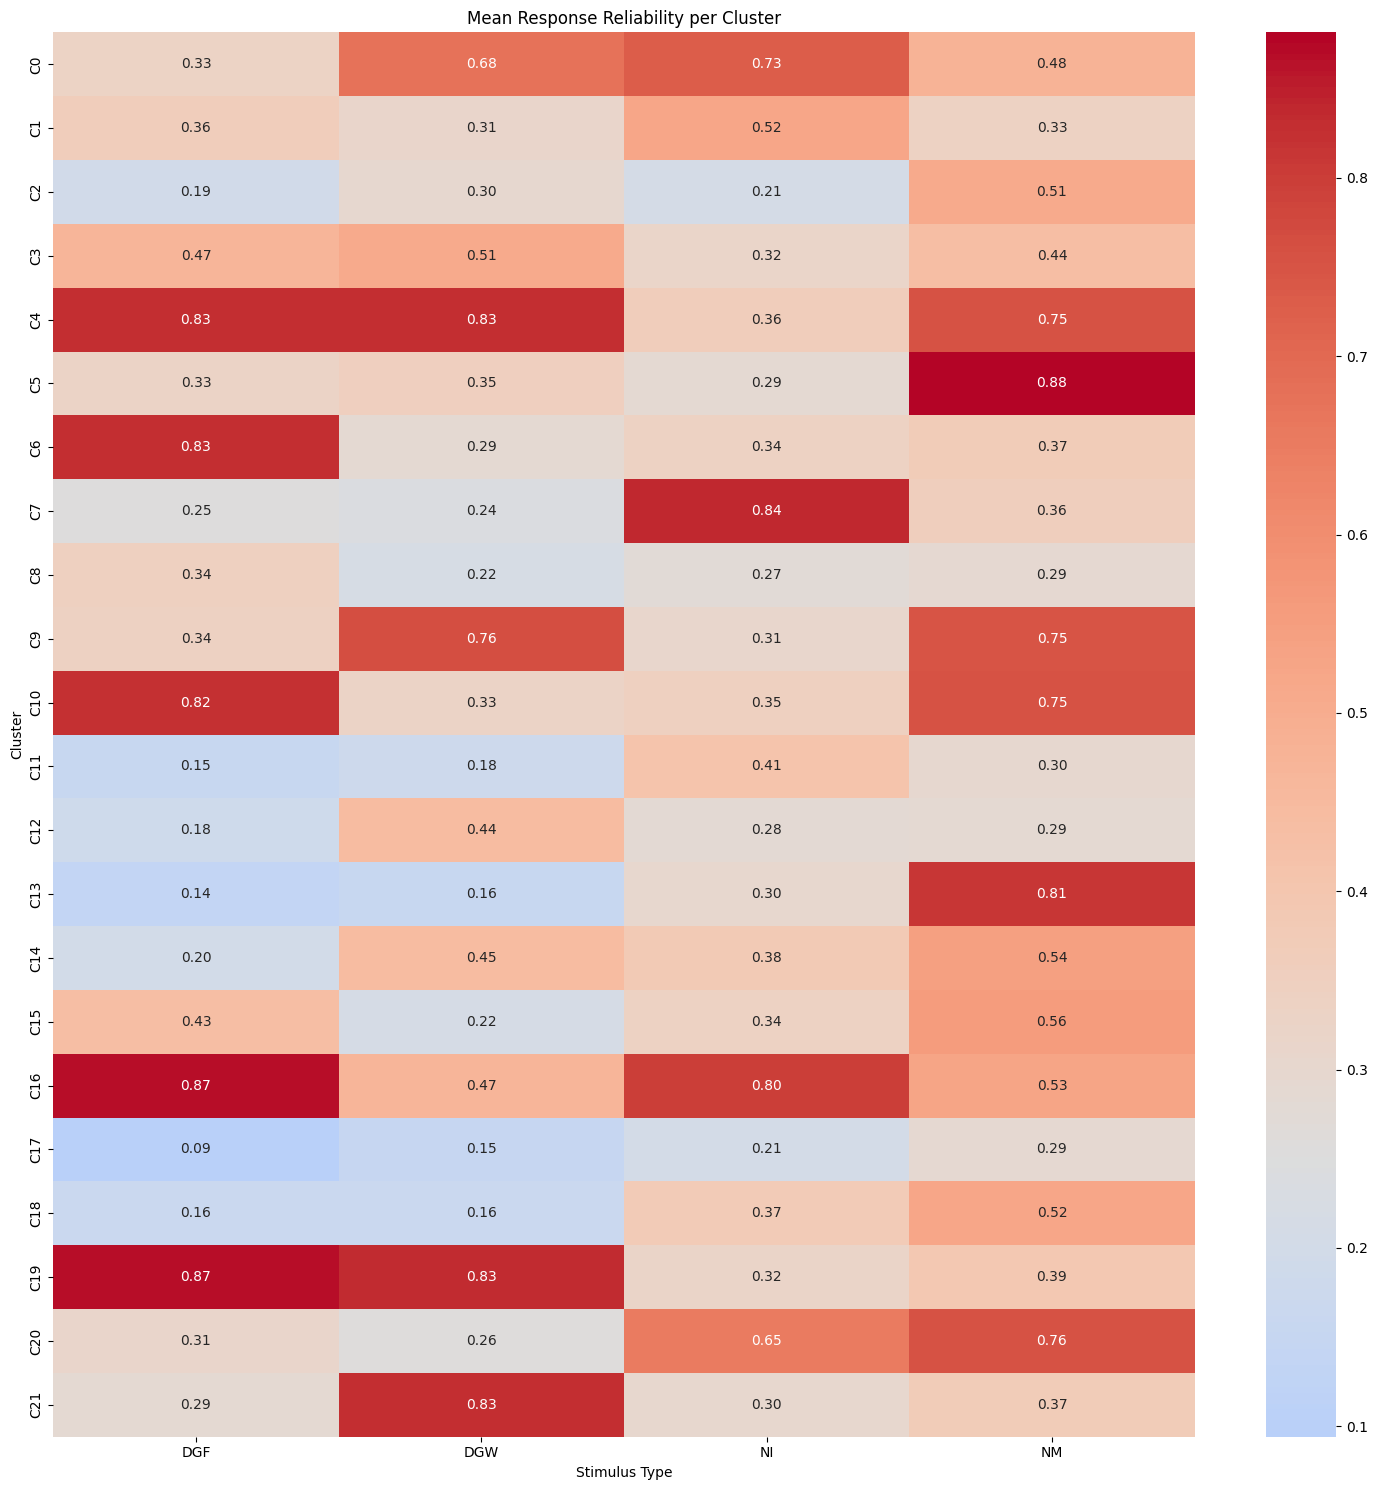

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

stim_labels = ['DGF', 'DGW', 'NI', 'NM']  # customize to your case
means = final_gmm.means_  # shape (k, 4)

plt.figure(figsize=(15, 15))
sns.heatmap(means, annot=True, fmt=".2f", cmap="coolwarm", center=0.25, xticklabels=stim_labels, yticklabels=[f"C{k}" for k in range(22)])
plt.title("Mean Response Reliability per Cluster")
plt.xlabel("Stimulus Type")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [ ]:
cluster_means = final_gmm.means_.mean(axis=1)  # shape: (n_clusters,)
nonresponsive_cluster = np.argmin(cluster_means)

# Extract all points in that cluster
nonresponsive_data = X[cluster_assignments == nonresponsive_cluster]

# Compute threshold
threshold = nonresponsive_data.max(axis=1).mean() + nonresponsive_data.max(axis=1).std()

In [14]:
class CustomGMM(GaussianMixture): 
    def __init__(self, n_components=1, *, random_state=None, **kwargs): 
        super().__init__(n_components=n_components, random_state=random_state, **kwargs) 
        self.all_results_ = []
    def fit(self, X, y=None):
        super().fit(X, y) 
        result = {
                "n_components": self.n_components,
                "random_state": self.random_state,
                "log_likelihood": self.lower_bound_,
                "weights": self.weights_,
                "means": self.means_,
                "covariances": self.covariances_ 
                } 
        self.all_results_.append(result) 
        return self
    
def sum_by_class(class_labels, values):
    if len(class_labels) != len(values):
        raise ValueError("Both arrays must have the same length.")

    class_sums = {}
    for class_label, value in zip(class_labels, values):
        if class_label not in class_sums:
            class_sums[class_label] = value
        else:
            class_sums[class_label] += value
    summed_values = np.array(list(class_sums.values()))
    return summed_values

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    return -estimator.bic(X)

Run the following cell only once (I already ran it and the results are saved under artifacts/custering). This is trying to replicate the GMM clustering suggested in de Vries paper. However, for some reason the number of optimal cluster is very close to the max_n_components. This needs some troubleshooting. However, I tried many different numbers and in the end the number of remaining cluster classes are very consistent regardless of this initial number of clusters.

In [ ]:
min_n_components = 1
max_n_components = 30
all_final_cluster_classes = []
all_unique_classes_sorted = []
all_summed_values = []
all_clusters = []
all_percent_neurons_in_mice = []
all_mean_reliab_in_clusters_sorted = []
all_new_class_idx_sorted = []
tag = "250904"

for init in range(100):
    param_grid = { 'n_components': list(range(min_n_components, max_n_components)),
                'random_state': [init]
                }
    custom_gmm = CustomGMM() 
    model = GridSearchCV(custom_gmm, param_grid, cv=4, n_jobs=-1, verbose=4, scoring=gmm_bic_score)
    model.fit(X) 
    print(f"Best Number of Clusters: {model.best_params_['n_components']} with Score: {-model.best_score_:.4f}")
    
    clusters = model.best_estimator_.predict(X)
    n_clusters = model.best_estimator_.means_.shape[0]
    n_groups = 4

    mean_reliab_in_clusters = np.zeros((n_clusters, n_groups))
    groups_in_cluster = np.zeros((n_clusters, n_groups))

    for cluster in range(n_clusters):
        for g in range(n_groups):
            cell_ind_in_cluster = np.where(clusters == cluster)[0]     
            reliabilities_in_cluster = X[cell_ind_in_cluster, g]
            mean_reliab_in_clusters[cluster, g] = np.nanmean(reliabilities_in_cluster)

    cluster_means = model.best_estimator_.means_
    cluster_means_array = np.mean(cluster_means, axis=1)
    cluster_ind_sorted = np.argsort(cluster_means_array)
    mean_reliab_in_clusters_sorted = mean_reliab_in_clusters[cluster_ind_sorted, :] 
    all_mean_reliab_in_clusters_sorted.append(mean_reliab_in_clusters_sorted)
    
    cluster_with_lowest_mean = cluster_ind_sorted[0]
    
    # threshold for each column
    threshold_for_each_column = mean_reliab_in_clusters[cluster_with_lowest_mean,:] + np.std(mean_reliab_in_clusters, axis = 0)
    thresh = threshold_for_each_column

    group_names = ["DGF","DGW","NI","NM"]
    group_names_arr = np.asarray(group_names, dtype=object)
    cluster_classes = []
    cluster_assignments = mean_reliab_in_clusters_sorted > thresh
    
    for cluster in range(n_clusters):
        cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
        cluster_classes.append(cluster_class)
    unique_classes = [list(x) for x in set(tuple(x) for x in cluster_classes)]
    unique_classes_sorted = sorted(unique_classes, key=len)

    classes = []
    for x in cluster_classes:
        index = unique_classes_sorted.index(x)
        classes.append(index)
    classes_arr = np.array(classes)
    new_class_idx_sorted = np.argsort(classes_arr)
    all_new_class_idx_sorted.append(new_class_idx_sorted)
    
    final_cluster_classes = []
    for cluster in range(n_clusters):
        final_cluster_classes.append(cluster_classes[new_class_idx_sorted[cluster]])
        
    final_classes = []
    for cluster_class in final_cluster_classes:
        index = unique_classes_sorted.index(cluster_class)
        final_classes.append(index)

    original_cluster_classes = []
    cluster_assignments = mean_reliab_in_clusters > thresh
    for cluster in range(n_clusters):
        cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
        original_cluster_classes.append(cluster_class)
    
    all_final_cluster_classes.append(final_cluster_classes)
    all_unique_classes_sorted.append(unique_classes_sorted)
   
    percent_neurons_in_cluster = []
    for cluster in new_class_idx_sorted:
        cell_ind_in_cluster_1_g0 = np.where((clusters == cluster))[0]
        percent_neurons_in_cluster.append(len(features.iloc[cell_ind_in_cluster_1_g0]) * 100/ len(features))
        
    summed_values = sum_by_class(final_classes, percent_neurons_in_cluster)
    all_summed_values.append(summed_values)
    all_clusters.append(clusters)

    unique_mice = cell_info.mouse_id.unique()
    percent_neurons_in_mouse = np.zeros((len(unique_mice)))

    for i, mouse in enumerate(unique_mice):
        mouse_cell_info = cell_info.loc[cell_info["mouse_id"] == mouse]

        percent_neurons_in_mouse[i] = len(mouse_cell_info)*100/ len(cell_info)
        
    all_percent_neurons_in_mice.append(percent_neurons_in_mouse)

os.makedirs(ARTIFACT_DIR / "clustering", exist_ok=True)

open_file = open(ARTIFACT_DIR / "clustering" / f"all_final_cluster_classes_{tag}.pkl", "wb")
pickle.dump(all_final_cluster_classes, open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" / f"all_unique_classes_sorted_{tag}.pkl", "wb")
pickle.dump(all_unique_classes_sorted, open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" / f"all_summed_values_{tag}.pkl", "wb")
pickle.dump(all_summed_values, open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" / f"all_clusters_{tag}.pkl", "wb")
pickle.dump(all_clusters, open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" / f"all_percent_neurons_in_mice_{tag}.pkl", "wb")
pickle.dump(all_percent_neurons_in_mice, open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" / f"all_mean_reliab_in_clusters_sorted_{tag}.pkl", "wb")
pickle.dump(all_mean_reliab_in_clusters_sorted, open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" / f"all_new_class_idx_sorted_{tag}.pkl", "wb")
pickle.dump(all_new_class_idx_sorted, open_file)
open_file.close()

Fitting 4 folds for each of 29 candidates, totalling 116 fits
[CV 2/4] END n_components=1, random_state=0;, score=-1332.246 total time=   0.0s
[CV 1/4] END n_components=1, random_state=0;, score=18627.877 total time=   0.0s
[CV 3/4] END n_components=1, random_state=0;, score=14203.510 total time=   0.1s
[CV 4/4] END n_components=1, random_state=0;, score=13362.933 total time=   0.2s
[CV 1/4] END n_components=3, random_state=0;, score=24049.574 total time=   0.6s
[CV 2/4] END .n_components=2, random_state=0;, score=9883.789 total time=   0.6s
[CV 4/4] END n_components=2, random_state=0;, score=21492.676 total time=   0.7s
[CV 3/4] END n_components=2, random_state=0;, score=24085.152 total time=   0.8s
[CV 1/4] END n_components=2, random_state=0;, score=23354.653 total time=   0.8s
[CV 3/4] END n_components=5, random_state=0;, score=30003.092 total time=   1.5s
[CV 2/4] END n_components=3, random_state=0;, score=13210.360 total time=   1.6s
[CV 3/4] END n_components=6, random_state=0;, s

/tmp/ipykernel_466537/4250642579.py:32: RuntimeWarning: Mean of empty slice
  mean_reliab_in_clusters[cluster, g] = np.nanmean(reliabilities_in_cluster)


[CV 3/4] END n_components=2, random_state=43;, score=24082.178 total time=   0.7s
[CV 2/4] END n_components=2, random_state=43;, score=9877.632 total time=   0.7s
[CV 4/4] END n_components=3, random_state=43;, score=21972.805 total time=   0.8s
[CV 2/4] END n_components=4, random_state=43;, score=13073.974 total time=   0.8s
[CV 1/4] END n_components=2, random_state=43;, score=23355.797 total time=   0.9s
[CV 4/4] END n_components=2, random_state=43;, score=21493.370 total time=   0.9s
[CV 4/4] END n_components=4, random_state=43;, score=21521.351 total time=   0.9s
[CV 1/4] END n_components=4, random_state=43;, score=22197.524 total time=   1.0s
[CV 3/4] END n_components=4, random_state=43;, score=28002.145 total time=   1.1s
[CV 2/4] END n_components=5, random_state=43;, score=16455.684 total time=   1.2s
[CV 3/4] END n_components=5, random_state=43;, score=29999.510 total time=   1.3s
[CV 3/4] END n_components=6, random_state=43;, score=30524.962 total time=   1.5s
[CV 2/4] END n_co

FileNotFoundError: [Errno 2] No such file or directory: '/home/naomi/Desktop/code/v1dd-public/artifacts/clustering/all_final_cluster_classes_{tag}.pkl'

In [18]:
saved_model = joblib.load(ARTIFACT_DIR / "clustering" / f'grid_search_{min_n_components}_{max_n_components}_clusters_100_initializations_{tag}_no_lsn_ni12.pkl')

print(f"Best Number of Clusters: {saved_model.best_params_['n_components']} with Score: {-saved_model.best_score_:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/naomi/Desktop/code/v1dd-public/artifacts/clustering/grid_search_1_30_clusters_100_initializations_250904_no_lsn_ni12.pkl'

#### Load results for clusters and 100 iterations

In [19]:
open_file = open(ARTIFACT_DIR/ "clustering" /f"all_final_cluster_classes_{tag}.pkl", "rb")
all_final_cluster_classes = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /f"all_unique_classes_sorted_{tag}.pkl", "rb")
all_unique_classes_sorted = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /f"all_summed_values_{tag}.pkl", "rb")
all_summed_values = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /f"all_clusters_{tag}.pkl", "rb")
all_clusters = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /f"all_percent_neurons_in_mice_{tag}.pkl", "rb")
all_percent_neurons_in_mice = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /f"all_mean_reliab_in_clusters_sorted_{tag}.pkl", "rb")
all_mean_reliab_in_clusters_sorted = pickle.load(open_file)
open_file.close()

open_file = open(ARTIFACT_DIR / "clustering" /f"all_new_class_idx_sorted_{tag}.pkl", "rb")
all_new_class_idx_sorted = pickle.load(open_file)
open_file.close()

Here I ran the analysis with 29 clusters despite the fact that the optimal number of clusters was 48 (I did anotehr run from 1-30 which gave me 29 as the number of optimal clusters but unfortunately I did not save that run, but you can run it again)

In [ ]:
all_final_cluster_classes = []
all_unique_classes_sorted = []
all_summed_values = []
all_percent_neurons_in_mice = []
all_new_class_idx_sorted = []

for init in range(100):
    
    clusters = all_clusters[init]
    n_clusters = 29
    n_groups = 4

    mean_reliab_in_clusters = all_mean_reliab_in_clusters_sorted[init]
    
    # This is the threshold based on de Vries paper
    cluster_with_lowest_mean = 0
    threshold2 = np.max(mean_reliab_in_clusters[cluster_with_lowest_mean,:]) +\
        np.std(mean_reliab_in_clusters[cluster_with_lowest_mean,:])
    
    # you can comment the lines above and run the rest of the analyis using 3 different thresholds as in the supplmentary figure 
    # threshold2 = 0.75 # 0.25, 0.5

    group_names = ["DGF","DGW","NI","NM"]
    group_names_arr = np.asarray(group_names, dtype=object)
    cluster_classes = []
    cluster_assignments = mean_reliab_in_clusters > threshold2
    
    for cluster in range(n_clusters):
        cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
        cluster_classes.append(cluster_class)
    unique_classes = [list(x) for x in set(tuple(x) for x in cluster_classes)]
    unique_classes_sorted = sorted(unique_classes, key=len)

    classes = []
    for x in cluster_classes:
        index = unique_classes_sorted.index(x)
        classes.append(index)
    classes_arr = np.array(classes)
    new_class_idx_sorted = np.argsort(classes_arr)
    all_new_class_idx_sorted.append(new_class_idx_sorted)
    
    final_cluster_classes = []
    for cluster in range(n_clusters):
        final_cluster_classes.append(cluster_classes[new_class_idx_sorted[cluster]])
        
    final_classes = []
    for cluster_class in final_cluster_classes:
        index = unique_classes_sorted.index(cluster_class)
        final_classes.append(index)

    original_cluster_classes = []
    for cluster in range(n_clusters):
        cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
        original_cluster_classes.append(cluster_class)
    
    all_final_cluster_classes.append(final_cluster_classes)
    all_unique_classes_sorted.append(unique_classes_sorted)
   
    percent_neurons_in_cluster = []
    for cluster in new_class_idx_sorted:
        cell_ind_in_cluster_1_g0 = np.where((clusters == cluster))[0]
        percent_neurons_in_cluster.append(len(features.iloc[cell_ind_in_cluster_1_g0]) * 100/ len(features))
        
    summed_values = sum_by_class(final_classes, percent_neurons_in_cluster)
    all_summed_values.append(summed_values)
    
    unique_mice = cell_info.mouse_id.unique()
    percent_neurons_in_mouse = np.zeros((len(unique_mice)))

    for i, mouse in enumerate(unique_mice):
        mouse_cell_info = cell_info.loc[cell_info["mouse_id"] == mouse]

        percent_neurons_in_mouse[i] = len(mouse_cell_info)*100/ len(cell_info)
        
    all_percent_neurons_in_mice.append(percent_neurons_in_mouse)

In [68]:
all_final_cluster_classes

[[[],
  ['DGW'],
  ['DGW'],
  ['NI'],
  ['NI'],
  ['NM'],
  ['NM'],
  ['DGF'],
  ['DGF', 'NM'],
  ['DGF', 'NM'],
  ['NI', 'NM'],
  ['DGW', 'NM'],
  ['DGF', 'DGW', 'NM'],
  ['DGF', 'DGW', 'NI', 'NM']],
 [[],
  [],
  [],
  ['DGW'],
  ['DGW'],
  ['DGW'],
  ['NI'],
  ['NI'],
  ['NM'],
  ['NM'],
  ['NM'],
  ['NM'],
  ['DGF'],
  ['DGF', 'DGW'],
  ['DGF', 'DGW'],
  ['DGF', 'DGW'],
  ['DGF', 'NM'],
  ['DGF', 'NM'],
  ['DGF', 'NM'],
  ['DGW', 'NI'],
  ['NI', 'NM'],
  ['DGW', 'NM'],
  ['DGW', 'NM'],
  ['DGF', 'DGW', 'NI'],
  ['DGF', 'DGW', 'NM'],
  ['DGF', 'DGW', 'NM'],
  ['DGF', 'DGW', 'NM'],
  ['DGF', 'DGW', 'NI', 'NM'],
  ['DGF', 'DGW', 'NI', 'NM']],
 [[],
  ['DGW'],
  ['DGW'],
  ['NI'],
  ['NI'],
  ['NM'],
  ['NM'],
  ['DGF'],
  ['DGF'],
  ['DGF', 'DGW'],
  ['DGW', 'NI'],
  ['DGF', 'NM'],
  ['NI', 'NM'],
  ['DGW', 'NM'],
  ['DGF', 'DGW', 'NM'],
  ['DGF', 'DGW', 'NI', 'NM']],
 [[],
  [],
  [],
  ['DGW'],
  ['DGW'],
  ['NI'],
  ['NM'],
  ['NM'],
  ['DGF'],
  ['DGF', 'DGW'],
  ['DGF', 'DGW'],
 

In [21]:
all_final_cluster_classes[0]

[[],
 ['DGW'],
 ['DGW'],
 ['NI'],
 ['NI'],
 ['NM'],
 ['NM'],
 ['DGF'],
 ['DGF', 'NM'],
 ['DGF', 'NM'],
 ['NI', 'NM'],
 ['DGW', 'NM'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NI', 'NM']]

 19%|█▉        | 19/100 [5:17:46<22:34:41, 1003.48s/it]


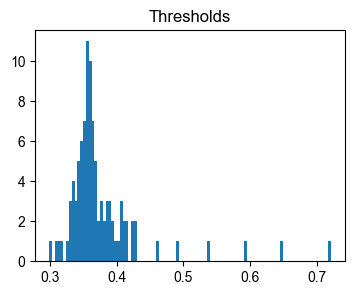

In [22]:
thresholds = []

for init in range(100):
    mean_reliab_in_clusters = all_mean_reliab_in_clusters_sorted[init]
    cluster_with_lowest_mean = 0 # it is already sorted
    threshold2 = np.max(mean_reliab_in_clusters[cluster_with_lowest_mean,:]) +\
        np.std(mean_reliab_in_clusters[cluster_with_lowest_mean,:])
    thresholds.append(threshold2)
    
plt.figure(figsize=((4,3)))
plt.hist(thresholds, 100)
plt.title('Thresholds')
plt.show()

### Define all unique cluster classes

In [23]:
ordered_clusters = [
    [],
    ['DGF'],
    ['DGW'],
    ['DGF', 'DGW'],
    ['NI'],
    ['DGF', 'NI'],
    ['DGW', 'NI'],
    ['DGF', 'DGW', 'NI'],
    ['NM'],
    ['DGF', 'NM'],
    ['DGW', 'NM'],
    ['DGF', 'DGW', 'NM'],
    ['NI', 'NM'],
    ['DGW', 'NI', 'NM'],
    ['DGF', 'NI', 'NM'],
    ['DGF', 'DGW', 'NI', 'NM']
]

In [24]:
def plot_mean_values_above_threshold_colored_order(data, values, ordered_clusters, threshold=0, plot=1, return_sorted=0): 
    # This function include 0s in mean and std
    flattened_data = [str(lst) for member in data for lst in member] 
    union_labels = list(set(flattened_data))
    means = [] 
    errors = [] 
    labels = [] 
    label_index = []
    for ilabel, label in enumerate(union_labels): 
        corresponding_values = [] 
        count = 0
        for i, member in enumerate(data): 
            for j, sublist in enumerate(member): 
                if str(sublist) == label: 
                    if isinstance(values[i][j], (list, np.ndarray)):
                        corresponding_values.extend(values[i][j].tolist()) 
                    else:
                        corresponding_values.append(values[i][j]) 
                        count += 1
        if count < threshold:
            continue
        label_index.append(ilabel)
        
        
        corresponding_values_2 = corresponding_values + [0] * (100 - len(corresponding_values))
        mean = np.mean(corresponding_values_2) 
        std_error = np.std(corresponding_values_2) / np.sqrt(len(corresponding_values_2)) 
        means.append(mean) 
        errors.append(std_error) 
        labels.append(label)
    sorted_indices = np.argsort(means)[::-1] 
    means = np.array(means)[sorted_indices].tolist() 
    errors = np.array(errors)[sorted_indices].tolist()
    labels = np.array(labels)[sorted_indices].tolist()
    new_labels = [ast.literal_eval(label) for label in labels]

    indices = [new_labels.index(label) if label in new_labels else -1 for label in ordered_clusters]
    new_means = [means[i] if i != -1 else 0 for i in indices]
    new_errs = [errors[i] if i != -1 else 0 for i in indices]
    newer_labels = [str(label) for label in ordered_clusters]
    
    n_colors = 16
    color_palette = sns.husl_palette(n_colors)
    
    if plot:
        fig = plt.figure(figsize=(10, 7)) 
        bars = plt.bar(newer_labels, new_means, yerr=new_errs, capsize=5, color=color_palette) 
        plt.xticks(rotation=45, ha="right", fontsize=10) 
        plt.yticks(fontsize=10) 
        plt.ylabel('Percent of neurons', fontsize=14) 
        plt.tight_layout() 
        plt.ylim([0, 40])
        # fig.savefig(f"clustering_no_lsn_ni12_29_clusters threshold={threshold2}_{tag}.eps", format='eps')
        
    if return_sorted:
        return sorted_indices, indices, label_index

In [25]:
all_unique_classes_sorted[0]

[[],
 ['DGW'],
 ['NI'],
 ['NM'],
 ['DGF'],
 ['DGF', 'NM'],
 ['NI', 'NM'],
 ['DGW', 'NM'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NI', 'NM']]

In [38]:
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

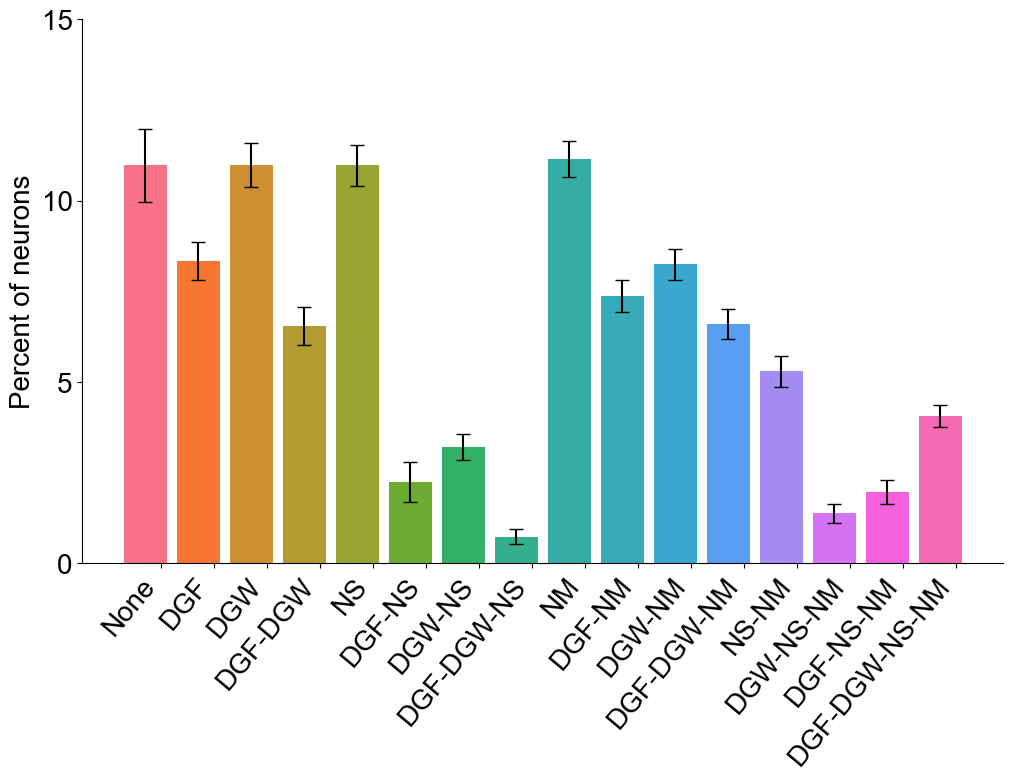

In [58]:
plot_mean_values_above_threshold_colored_order(all_unique_classes_sorted, all_summed_values, \
    ordered_clusters, threshold=0)

fontsize=20
plt.xticks(np.arange(0.3, 16.3, 1), ['None', 'DGF', 'DGW', 'DGF-DGW', 'NS', 'DGF-NS', 'DGW-NS', 'DGF-DGW-NS', 'NM', 'DGF-NM', 'DGW-NM', 'DGF-DGW-NM', 'NS-NM', 'DGW-NS-NM', 'DGF-NS-NM', 'DGF-DGW-NS-NM'], rotation=50, ha="right", fontsize=fontsize);
plt.ylim(0, 15)
plt.ylabel('Percent of neurons', fontsize=fontsize)
plt.yticks(np.arange(0, 20, 5), fontsize=fontsize); 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG4E_clustering_summary_threshold={threshold2}_{tag}.png'), dpi=300)

#### Plot the clusters for 1 example iteration

In [59]:
cmap_data = { 'red': [(0, 0, 0), (0.25, 1, 1), (0.4,1,1), (1, 0.9, 0.9)], 'green': [(0, 0, 0), (0.25, 1, 1), (0.4,0.45,0.45), (1, 0, 0)], 'blue': [(0, 1, 1), (0.25, 1, 1),(0.4,0.45,0.45), (1, 0, 0)] } 
dark_red_bwr = LinearSegmentedColormap('dark_red_bwr', cmap_data) 

In [76]:
all_mean_reliab_in_clusters_sorted[1]

array([[0.07960722, 0.15472995, 0.25760379, 0.28213693],
       [0.31184085, 0.17702212, 0.2034627 , 0.28177628],
       [0.13432634, 0.08941706, 0.32982214, 0.53028555],
       [0.16516492, 0.453615  , 0.19914139, 0.28868555],
       [0.31877007, 0.1839373 , 0.41629137, 0.28881208],
       [0.11403058, 0.157748  , 0.56078337, 0.31295508],
       [0.20223605, 0.30716858, 0.19963758, 0.54218104],
       [0.16818681, 0.45095585, 0.44157825, 0.29009873],
       [0.46756548, 0.44456707, 0.20024142, 0.31048919],
       [0.14256232, 0.16411142, 0.27235526, 0.84846839],
       [0.20452876, 0.32334547, 0.43335068, 0.537228  ],
       [0.46162477, 0.18368063, 0.35407489, 0.54216226],
       [0.46092842, 0.43160145, 0.47319961, 0.31727685],
       [0.79539679, 0.17388863, 0.35043294, 0.34720992],
       [0.17703847, 0.59701475, 0.3267663 , 0.545625  ],
       [0.18331174, 0.15867167, 0.64965986, 0.77086378],
       [0.28022141, 0.25264627, 0.85081557, 0.35057153],
       [0.29625776, 0.84703178,

In [77]:
all_final_cluster_classes[1]

[[],
 [],
 [],
 ['DGW'],
 ['DGW'],
 ['DGW'],
 ['NI'],
 ['NI'],
 ['NM'],
 ['NM'],
 ['NM'],
 ['NM'],
 ['DGF'],
 ['DGF', 'DGW'],
 ['DGF', 'DGW'],
 ['DGF', 'DGW'],
 ['DGF', 'NM'],
 ['DGF', 'NM'],
 ['DGF', 'NM'],
 ['DGW', 'NI'],
 ['NI', 'NM'],
 ['DGW', 'NM'],
 ['DGW', 'NM'],
 ['DGF', 'DGW', 'NI'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NM'],
 ['DGF', 'DGW', 'NI', 'NM'],
 ['DGF', 'DGW', 'NI', 'NM']]

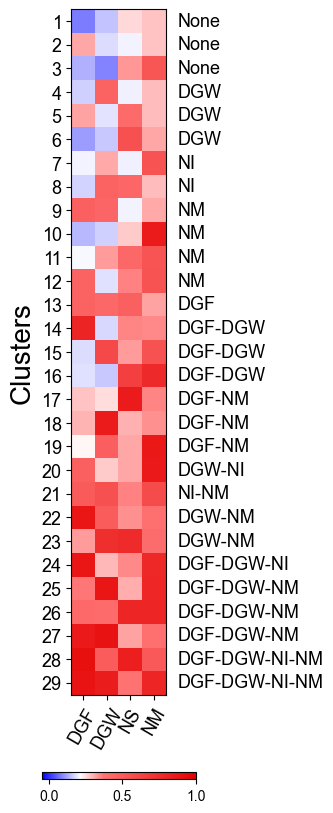

In [115]:
iter_num = 1
mean_reliab_in_clusters_sorted = all_mean_reliab_in_clusters_sorted[iter_num]
thresh = 0.05
plt.figure(figsize=(20,10))
cm = plt.imshow(mean_reliab_in_clusters_sorted, cmap=dark_red_bwr)
cbar = plt.colorbar(cm, fraction=0.01,  pad=0.1, location='bottom')
plt.clim(vmin = -np.min(thresh),vmax = 1)

for i, cluster_class in enumerate(all_final_cluster_classes[iter_num]):
    if len (cluster_class) == 0:
        cluster_class = 'None'
    elif len(cluster_class) == 1:
        cluster_class = cluster_class[0]
    elif len(cluster_class) > 1:
        cluster_class = '-'.join(cluster_class)
    plt.text(4, i, str(cluster_class), fontsize=13, verticalalignment='center')

plt.yticks(np.arange(0, mean_reliab_in_clusters_sorted.shape[0], 1), np.arange(1, mean_reliab_in_clusters_sorted.shape[0]+1, 1), fontsize=13)
plt.xticks(np.arange(0, mean_reliab_in_clusters_sorted.shape[1], 1), ['DGF', 'DGW', 'NS', 'NM'], fontsize=13, rotation=60)
plt.ylabel('Clusters', fontsize=20)
plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG4D_heatmap_of_clusters_threshold={threshold2}_{tag}.png'), dpi=300)

In [ ]:
mean_reliab_in_clusters_sorted

array([[0.07510784, 0.0900876 , 0.2573324 , 0.28207635],
       [0.19858588, 0.30822463, 0.19617945, 0.28483936],
       [0.08100793, 0.08760378, 0.30779416, 0.53689045],
       [0.30660338, 0.11679514, 0.28983583, 0.28604338],
       [0.14266238, 0.11918875, 0.55342301, 0.29697191],
       [0.08403894, 0.31148702, 0.30019014, 0.53418641],
       [0.21125085, 0.31592751, 0.43033168, 0.29510617],
       [0.15904117, 0.55005874, 0.28693262, 0.30807803],
       [0.32729417, 0.17814224, 0.3158658 , 0.56085378],
       [0.117335  , 0.14010317, 0.2979446 , 0.85295813],
       [0.55116118, 0.23503725, 0.27351304, 0.35835938],
       [0.19013969, 0.24940781, 0.57989966, 0.5900975 ],
       [0.46263194, 0.55401231, 0.30703217, 0.29511464],
       [0.2885227 , 0.48093532, 0.32174936, 0.54899368],
       [0.48888129, 0.25776869, 0.57727804, 0.36084372],
       [0.26171625, 0.24669436, 0.8674015 , 0.34410048],
       [0.23401186, 0.83880106, 0.29508377, 0.3793561 ],
       [0.87554124, 0.17467354,

In [ ]:
cluster_assignments

array([[False, False, False, False],
       [False, False,  True, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False,  True],
       [False, False, False,  True],
       [False,  True, False, False],
       [False, False, False,  True],
       [ True,  True, False, False],
       [False, False,  True,  True],
       [False, False,  True, False],
       [ True, False, False,  True],
       [False,  True, False,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False,  True, False],
       [False,  True, False,  True],
       [ True, False, False,  True],
       [ True, False, False,  True],
       [ True,  True, False,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False,  True, False,  True],
       [ True, False, False,  True],
       [ True,  True, False,  True],
       [ True, False,  True,  True],
 

In [ ]:
cluster_assignments = mean_reliab_in_clusters_sorted > threshold2
group_names = ["DGF","DGW","NI","NM"]
group_names_arr = np.asarray(group_names, dtype=object)
    
for cluster in range(n_clusters):
    cluster_class = group_names_arr[cluster_assignments[cluster]].tolist()
    print(cluster_class)

[]
[]
['NM']
[]
['NI']
['NM']
['NI']
['DGW']
['NM']
['NM']
['DGF']
['NI', 'NM']
['DGF', 'DGW']
['DGW', 'NM']
['DGF', 'NI']
['NI']
['DGW', 'NM']
['DGF', 'NM']
['NM']
['DGF', 'DGW', 'NI', 'NM']
['DGW', 'NI', 'NM']
['DGF', 'DGW', 'NM']
['DGW', 'NM']
['NI', 'NM']
['DGF', 'DGW', 'NM']
['DGF', 'NM']
['DGF', 'DGW', 'NI', 'NM']
['DGF', 'DGW', 'NI', 'NM']
['DGF', 'DGW', 'NI', 'NM']


#### Find the union of clusters across 100 iterations

In [ ]:
def union_lists(data):
    result = [] 
    for member in data:
        for lst in member: 
            if lst not in result: 
                result.append(lst) 
    return result 

cluster_union = union_lists(all_unique_classes_sorted) 
print(f"There are {len(cluster_union)} unique clusters across 100 iterations.")

There are 16 unique clusters across 100 iterations.


#### Plot percent for each mouse and each cluster

In [ ]:
flattened_data = [str(lst) for member in all_unique_classes_sorted for lst in member] 
union_classes = list(set(flattened_data)) 
len(union_classes)

16

In [ ]:
unique_mice = cell_info.mouse_id.unique()
all_percent_neurons_in_cluster_class_mouse_80 = np.zeros((100,len(union_classes), len(unique_mice)))
union_classes_lst_of_lsts = [ast.literal_eval(item) for item in union_classes]


In [ ]:
def create_output_array(a, b, c): 
    output = np.zeros(len(a))
    for i, element_a in enumerate(a):
        if element_a in b:
            idx = b.index(element_a) 
            output[i] = c[idx] 
    return output

In [ ]:
def sum_by_class(class_labels, values):
    if len(class_labels) != len(values):
        raise ValueError("Both arrays must have the same length.")
    class_sums = {}
    for class_label, value in zip(class_labels, values):
        if class_label not in class_sums:
            class_sums[class_label] = value
        else:
            class_sums[class_label] += value
    summed_values = np.array(list(class_sums.values()))

    return summed_values

In [ ]:

for iter_num in range(100):
    clusters = all_clusters[iter_num]
    new_class_idx_sorted = all_new_class_idx_sorted[iter_num]
    unique_classes_sorted = all_unique_classes_sorted[iter_num]
    final_cluster_classes = all_final_cluster_classes[iter_num]

    final_classes = []
    for cluster_class in final_cluster_classes:
        index = unique_classes_sorted.index(cluster_class)
        final_classes.append(index)
  
    percent_neurons_in_cluster_class_mouse = np.zeros((len(unique_classes_sorted), len(unique_mice)))
    mean_percent_neurons_in_cluster_mouse = np.zeros((len(new_class_idx_sorted), len(unique_mice)))

    for i, mouse in enumerate(unique_mice):
        for cluster in new_class_idx_sorted:
            mouse_cell_info = cell_info.loc[cell_info["mouse_id"] == mouse]

            cell_ind_in_cluster_mouse = np.where((clusters == cluster))[0]
            cluster_cell_info = cell_info.iloc[cell_ind_in_cluster_mouse]
            cluster_mouse_cell_info = cluster_cell_info.loc[cluster_cell_info["mouse_id"] == mouse]

            mean_percent_neurons_in_cluster_mouse[cluster, i] = len(cluster_mouse_cell_info)*100/ len(mouse_cell_info)
        percent_neurons_in_cluster_class_mouse[:,i] = sum_by_class(final_classes, mean_percent_neurons_in_cluster_mouse[:, i].tolist())
        
        all_percent_neurons_in_cluster_class_mouse_80[iter_num,:,i] = create_output_array(union_classes_lst_of_lsts, \
            unique_classes_sorted, percent_neurons_in_cluster_class_mouse[:,i]) 

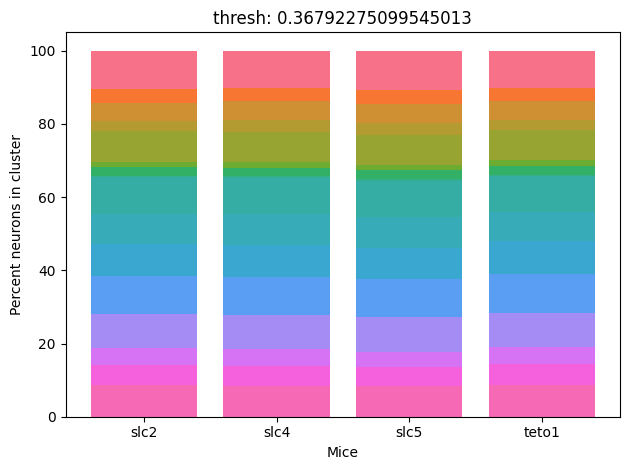

In [ ]:

sorted_indices_1, indices, iss = plot_mean_values_above_threshold_colored_order(all_unique_classes_sorted,\
    all_summed_values,ordered_clusters, threshold=0, plot=0, return_sorted=1)

percent_neurons_in_cluster_class_mouse = np.zeros((16,4))

for idx, val in enumerate(indices):
    if val != -1:
        percent_neurons_in_cluster_class_mouse[idx] = \
            np.mean(all_percent_neurons_in_cluster_class_mouse_80[:, sorted_indices_1[val], :], axis=0)


n_colors = 16#all_percent_neurons_in_cluster_class_mouse_80.shape[1]
color_palette = sns.husl_palette(n_colors)

data = percent_neurons_in_cluster_class_mouse
num_shades, num_bars = data.shape
x = np.arange(num_bars)
bar_width = 0.8
data_flipped = np.flip(data, axis=0)
color_palette_flipped = np.flip(color_palette, axis=0)
bottom = np.zeros(num_bars)
fig=plt.figure()
for i in range(num_shades):
    bar = plt.bar(x, data_flipped[i, :], width=bar_width, bottom=bottom, label=f'Shade {i+1}', color = color_palette_flipped[i% n_colors])
    bottom += data_flipped[i, :]
plt.xlabel('Mice')
plt.ylabel('Percent neurons in cluster')
plt.title(f"thresh: {threshold2}")
plt.xticks(x, ["slc2", "slc4", "slc5", "teto1"])
plt.tight_layout()
# fig.savefig(f"per_mouse_no_lsn_ni12_29_clusters threshold={threshold2}_{tag}.eps", format='eps')


### Plot percent for each depth

In [ ]:
z_groups_low_to_high = [[50, 66, 82], [98, 114, 130], [146, 162, 178], [194, 210, 226], [242, 258, 274], [290, 306, 322], [338, 354, 370], \
   [386, 402, 418], [434, 450, 466], [482, 498, 514], [500, 525, 550], [575, 600, 625], [650, 675, 700, 725]]

In [ ]:
total_vol_plane_pairs = len(z_groups_low_to_high)
all_percent_neurons_in_cluster_class_volume_80 = np.zeros((100,len(union_classes),13))


for iter_num in range(100):
    clusters = all_clusters[iter_num]
    new_class_idx_sorted = all_new_class_idx_sorted[iter_num]
    unique_classes_sorted = all_unique_classes_sorted[iter_num]
    final_cluster_classes = all_final_cluster_classes[iter_num]

    final_classes = []
    for cluster_class in final_cluster_classes:
        index = unique_classes_sorted.index(cluster_class)
        final_classes.append(index)
  
    percent_neurons_in_cluster_volume = np.zeros((len(new_class_idx_sorted), total_vol_plane_pairs))
    z_num = 0

    for z_group in z_groups_low_to_high:
            plane_volume_cell_info = cell_info.loc[cell_info["z"].isin(z_group)]
            for cluster in new_class_idx_sorted:
                cell_ind_in_cluster_1_g0 = np.where((clusters == cluster))[0]
                cluster_cell_info = cell_info.iloc[cell_ind_in_cluster_1_g0]
                cluster_volume_plane_cell_info = cluster_cell_info.loc[cluster_cell_info["z"].isin(z_group)]
                
                if len(plane_volume_cell_info) != 0:
                    percent_neurons_in_cluster_volume[cluster, z_num] = len(cluster_volume_plane_cell_info)*100/len(plane_volume_cell_info)
            if len(plane_volume_cell_info) != 0:
                z_num += 1
    percent_neurons_in_cluster_class_volume = np.zeros((len(unique_classes_sorted), total_vol_plane_pairs))

    for vol_plane_pair in range(total_vol_plane_pairs):

        percent_neurons_in_cluster_volume_list = percent_neurons_in_cluster_volume[:,vol_plane_pair].tolist()
        percent_neurons_in_cluster_class_volume[:,vol_plane_pair] = sum_by_class(final_classes, percent_neurons_in_cluster_volume_list)

        all_percent_neurons_in_cluster_class_volume_80[iter_num,:,vol_plane_pair] = \
            create_output_array(union_classes_lst_of_lsts, unique_classes_sorted,  \
                percent_neurons_in_cluster_class_volume[:,vol_plane_pair])

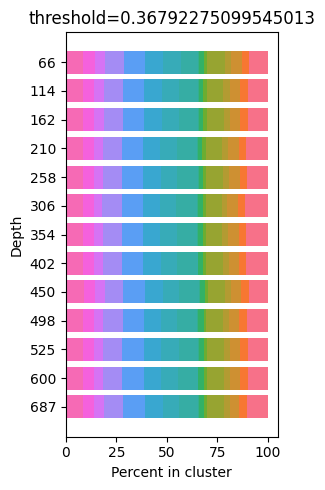

In [ ]:
sorted_indices_1, indices, iss = plot_mean_values_above_threshold_colored_order(all_unique_classes_sorted,\
    all_summed_values,ordered_clusters, threshold=0, plot=0, return_sorted=1)

all_percent_neurons_in_cluster_class_mouse_19_ordered = np.zeros((16,13))

for idx, val in enumerate(indices):
    if val != -1:
        all_percent_neurons_in_cluster_class_mouse_19_ordered[idx] = \
            np.mean(all_percent_neurons_in_cluster_class_volume_80[:, sorted_indices_1[val], :], axis=0)
data = np.array(all_percent_neurons_in_cluster_class_mouse_19_ordered)

n_colors = 16
color_palette = sns.husl_palette(n_colors)
color_palette_flipped = np.flip(color_palette, axis=0)

num_shades, num_bars = data.shape
x = np.arange(num_bars)
bar_width = 0.8
data_flipped = np.flip(data, axis=0)
bottom = np.zeros(num_bars)
means = [np.mean(group) for group in z_groups_low_to_high]
data_flipped = data_flipped[:, ::-1]
means = means[::-1]
x = np.arange(13)

fig = plt.figure(figsize=(3,5))
for i in range(num_shades):
    plt.barh(x, data_flipped[i, :], left=bottom, label=f'Shade {i+1}', color = color_palette_flipped[i% n_colors])
    bottom += data_flipped[i, :]
plt.xlabel('Percent in cluster')
plt.ylabel('Depth')
plt.yticks(ticks=x, labels=[f'{int(mean)}' for mean in means])
plt.title(f"threshold={threshold2}")
plt.tight_layout()
# fig.savefig(f"per_depth_no_lsn_ni12_29_clusters threshold={threshold2}_{tag}.eps", format='eps')